# ERP Preprocessing and Derivation Using MNE

This notebook reads in a raw, continuous EEG data file with trigger codes, saved in BrainVision `.vhdr` format, and preprocesses it (including filtering, segmentation, artifact detection/ICA correction), and plots means for each experimental condition, along with differences.

Note that for this to run, you need:
- Anaconda python and MNE installed on your computer (instructions below)
- this Jupyter notebook file
- the 3 raw files that are saved when you run an EEG subject (which end in `.vhdr`, `.vmrk`, and `.eeg`). 
 - _Do not rename these files_ — you will get an error when it tries to load your data, if you renamed the raw EEG files after recording. 
- This .ipynb notebook file, and the three raw data files, all need to be in the same directory (folder) in order for this to work. 

For each subject you analyze, you should *make a copy of this notebook file*, then change the appropriate lines (subject_id, trials/ICA components to remove). You definitely want to keep a record of what was done for each subject and what the results looked like, so don't just keep re-using the same notebook for each subject!



## Load in the necessary libraries/packages we'll need

In [1]:
import numpy as np
import matplotlib
import mne
from mne.io.reference import set_eeg_reference
mne.set_log_level('error')

## Set Parameters

### Subject name
This should be the name of the input files, without the extensions. So if your EEG files are `subj_01.eeg`, `subj_01.vhdr`, and `subj_01.vmrk`, then you would put `subj_01` here as the subject name. And yes, capitalization/exact spelling matters!

The script assumes that the raw data files are in the same folder as this jupyter notebook script.

In [2]:
subject = 'P4'

### Condition/Trigger Codes

For this script, we're using data from a sentence procesing study that basically tried to replicate the original Kutas & Hillyard (1980) N400 experiment, with an additional condition (violation words could be nouns OR adjectives):
- control words (e.g. last word in the sentence, "I take my coffee with milk and _sugar_."
- noun violations ("I take my coffee with milk and _dog_."
- adjective violations ("I take my coffee with milk and _slippery_.")

That should help you understand how the analysis shown here works. Additionally, to show how you might adapt this, let's say you had a face processing experiment. You used `1` as the code for fixation crosses between each stimulus (which you ultimately don't care about), `2` as the code for upright faces, and `3` as the code for inverted faces. 

`event_id` serves to match your numerical event trigger codes (sent form the stim program to the EEG system) with meaningful text labels.  So for our example, you would change this line to:
`event_id = {'fixation':1, 'upright':2, 'inverted':3}`

Finally, we can code for the contrasts (comparisons between conditions) that we are interested in — the things we'd like to create difference waves for. In this case, that would be the inverted-upright difference. We use `expt_contrasts` to give the contrast a meaningful text label (whatever you like):
`expt_contrasts = ('inv-up')`

...and then we use `expt_contrast_conds` to specify the things in cond_of_interest that we want to compare. The script below will subtract the second thing you list in `expt_contrast_conds` from the first thing you list, so in our example we'd use:
`expt_contrast_conds = [[cond_of_interest.index('inverted'), cond_of_interest.index('upright')]]`

Note that the contrast consists of two condition listings, separated by a comma, and inside square brackets. There's a second set of square brackets that surrounds the whole list of different contrasts you'll do. See the code in the cell below for an example with 3 contrasts.

Note that the template file I'm providing lists 3 event types and more contrasts, which should help you figure things out and get the formatting right if you have more than just two conditions of interest and one contrast.

#### Map each numerical trigger code that you want to average ERPs to, to a text label for that condition

In [3]:
event_id = {'Control':1, 'NounViol':2, 'AdjectiveViol':3}

cond_of_interest = sorted(event_id.keys())

#### Specify the between-condition differences you want to compute

Formally, you are creating a Python 'dictionary' where the keys (before the colon) are the labels for each contrast, and the values (in square brackets, after the colon) are a list of the two conditons you want to create. The second item in the list is subtracted from the first.

Practically, this means that each contrast is represented as a label, followed by a colon, followed by the names of the two conditions you want to compare. Those two names should be enclosed in square brackets with a comma between them. The names of the conditions need to be the ones you assigned to the codes in `event_id`, above


In [4]:
expt_contrasts = {'Noun-Ctrl':['NounViol','Control'], 
                  'Adj-Ctrl':['AdjectiveViol', 'Control'],
                  'Noun-Adj':['NounViol', 'AdjectiveViol']
                 }

### Epoch window
Specify the time for the start of the epoch (the baseline period, so it should be a negative number indicating how long before the code onset you want as a baseline), and the end (which is the time _after_ the onset of the code that you want). So your total epoch length will be the sum of the baseline and tmax.

In general, -0.2 for the baseline and 1.0 for the post-stimulus period will work fine, but in some cases you might want to change these (e.g., if your stimuli occurred less than 1 s from each other).

In [5]:
# Start of each epoch (in sec):
tmin = -0.2  

# End of each epoch (in sec)
tmax =  1.0  

### Other parameters 
You shouldn't need to change anything down here

In [9]:
# './' specifies that data are in the same directory as this notebook
data_path = 'data/' 

# Input should be continuous EEG data in EEGLAB format, named as [subject].set
raw_fname = data_path + subject + '.vhdr'

# Filter cutoffs and other parameters
l_freq = 0.1
h_freq = 40.0
l_trans_bandwidth = 'auto'
h_trans_bandwidth = 'auto'
filter_length='auto'

# maximum number of ICs to reject in ICA artifact correction
ica_random_state = 42  # seed so ICA is reproducable each time it's run

#################################################################
# It's unlikely you will want to change any settings below here

baseline = (None, 0)  # means from the first instant to t = 0
reject = dict(eeg=200e-6, eog=200e-6)  # EEG data are in V, so e-6 gives microVolts

# standard montage file to look up channel locations
montage_fname = 'standard_1005'

# output file names - set to follow MNE conventions
events_fname = data_path + subject + '-eve.fif'
epochs_fname  = data_path + subject + '-epo.fif'
evoked_fname = data_path + subject + '-ave.fif'

## Import data

In [10]:
raw = mne.io.read_raw_brainvision(raw_fname, 
                                  preload=True)  

## Filtering

### First plot frequency spectrum prior to filtering, for later comparison

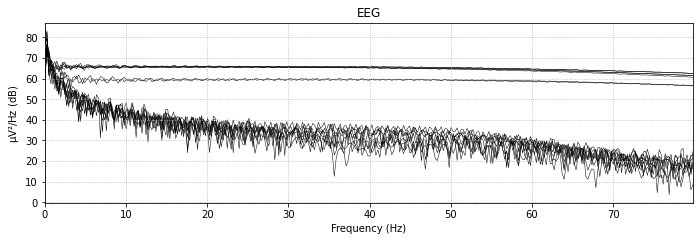

In [11]:
%matplotlib inline
raw.plot_psd(fmax=80, average=False, spatial_colors=True, line_alpha=1, n_jobs=4);

### Now bandpass filter, then plot filtered data

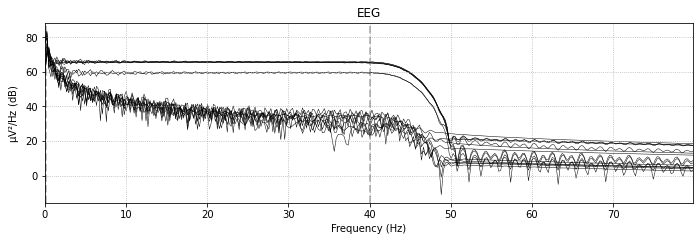

In [12]:
filt_eeg = raw.copy().filter(l_freq, h_freq, 
                             l_trans_bandwidth = l_trans_bandwidth, 
                             h_trans_bandwidth = h_trans_bandwidth, 
                             filter_length=filter_length, 
                             method='fft', 
                             n_jobs = 4)  

filt_eeg.plot_psd(fmax=80, average=False, spatial_colors=True, line_alpha=1, n_jobs=4);

## Interactive plot of continuous data - identify and mark bad channels
Scroll through the plot to identify channels for exclusion from analysis

Sometimes theinteractive plots fail to draw properly - and you'll just see a balck window, or it will draw but not be interactive. Just re-run the cell and it should work (eventually - mmay take a few tries). Also, you can rezise the plot with the grey triangle in the bottom right corner. This will flicker a lot and take some time to adjust. Be patient.


In [13]:
%matplotlib qt5 
filt_eeg.plot(n_channels=17, 
             scalings=dict(eeg=.0001), 
             duration=30, 
             title='Raw EEG'); 

ImportError: Failed to import any qt binding

#### List any bad channels that you found in the interactive plot, in 'bads':
e.g., `raw.info['bads'] = ['Oz']`

In [13]:
filt_eeg.info['bads'] = []

# Event Processing
Event codes are stored in a 'channel' called STI 014

### Visualize code positions over time

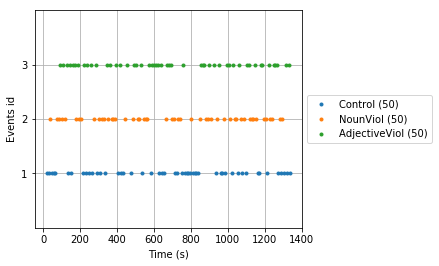

In [14]:
%matplotlib inline
fig = mne.viz.plot_events(filt_eeg._events, raw.info['sfreq'], event_id=event_id);

## Epoching

In [15]:
picks_eeg = mne.pick_types(filt_eeg.info, 
                           eeg=True, stim=False, 
                           exclude=[]) 

epochs = mne.Epochs(filt_eeg, 
                    filt_eeg._events, 
                    event_id, 
                    tmin, tmax, 
                    proj=False,
                    picks=picks_eeg, 
                    baseline=baseline, 
                    preload=True)

### Print # of epochs in each condition

In [16]:
print(epochs) # gives us number of trials per condition prior to artrej

<Epochs  |   150 events (all good), -0.2 - 1 sec, baseline [None, 0], ~11.0 MB, data loaded,
 'AdjectiveViol': 50
 'Control': 50
 'NounViol': 50>


## Plot epochs and go through, manually marking bad trials
Click on a trial to mark it bad. When you close the window, the marked trials will be saved to the "drops" in the epochs data structure.

In [17]:
%matplotlib qt5 
epochs.plot(scalings=dict(eeg=.0001), 
            n_channels=16, 
            title='Epochs', 
            picks=picks_eeg);

#### Reproducable science
The problem with manual rejection through the GUI is that we don't have a record here in the script of which trials were rejected. So if we have to redo this step, it might be done differently, which will affect all subsequent steps (notably ICA).

Therefore, we identify the bad trials visually, but exclude them manually by listing them in the cell below (as numbers, separated by commas — the numbers at the bottom of the epochs plot are the ones you want to use).

Note that an alternative way to reject trials is to click on them in the interactive plot above (what I call the "click-to-reject" approach). The trial will turn red and is then removed from the data structure for all subsequent steps. 
*BE CAREFUL* though, becuase *MNE renumbers the trials after rejection*. So, if you click on trials in the interactive plot, then list those trial numbers below and run `epochs.drop`, you will remove *double* the number of trials you intended - the latter half being actually-good trials.
Also, the "click" method is not a reproducible science approach, because if you re-run this notebook, you will have to re-identify and -mark the bad trials. So **do not use the click-to-reject approach**. If you accidentally click on a trial and it turns red, just click again to make it black before going on to the next cell.


In [18]:
rej_trials = [150]
# indices in epochs.plot() start from 1, not 0, so we need to -1 from each index we manually identified
for k in range(len(rej_trials)):
    rej_trials[k] = rej_trials[k]-1
    
epochs.drop(rej_trials)

<Epochs  |   149 events (all good), -0.2 - 1 sec, baseline [None, 0], ~11.0 MB, data loaded,
 'AdjectiveViol': 50
 'Control': 49
 'NounViol': 50>

### Plot average of all epochs
You should see big artifacts in the data, since we haven't done artifact correction yet. 

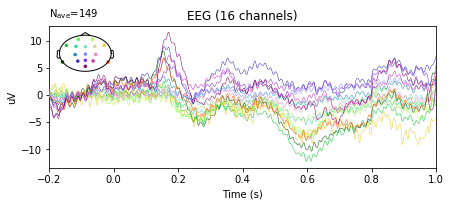

In [19]:
%matplotlib inline
epochs.average().plot(spatial_colors=True);

# Run ICA to identify and correct ocular artifacts

In [20]:
# Specify n_components as a decimal to set % explained variance
n_components = .975

ica = mne.preprocessing.ICA(n_components=n_components, method='fastica', 
                            max_iter=500, random_state=ica_random_state)

picks = mne.pick_types(epochs.info, eeg=True, meg=False, eog=False, stim=False, 
                       exclude='bads')

ica.fit(epochs, picks=picks, decim=3, reject=None)

<ICA  |  epochs decomposition, fit (fastica): 29949 samples, 10 components, channels used: "eeg">

### Plot scalp maps of each Independent Component
Ocular artifact components should load heavily over the front of the head and little/not at all elsewhere.

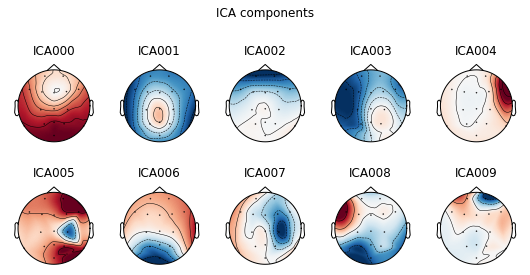

In [21]:
ica.plot_components(picks=None, ch_type='eeg');

### Plot individual components and do manual artifact selection

My criteria for rejection are:
1. Obvious ocular artifact (blinks weigh heavily on anterior channels, all same polarity; horizontal movements weight heavily on either side of the eyes, with opposite polarity on each side)
- Raster plots show that component weights heavily on a very low number of trials, and little/not at all on most trials
- "Epochs variance" is high on a low number of trials, and generally low on most trials
- Topo plot shows a very focal effect around a single electrode, with very little/no weighting at most other electrodes (keeping in mind that the topo plots are interpolated so there will be some "smearing" of an effect even at a single electrode) 
- No apparent correlation between average waveform (shown in bottom of raster plot) and an IC with a clear, strong, sensory ERP (i.e., no suggestion of part or all of a P1-N-P2 complex)

Need to manually change the "picks" number for each plot based on visual inspection of the topo plots of the components, above.

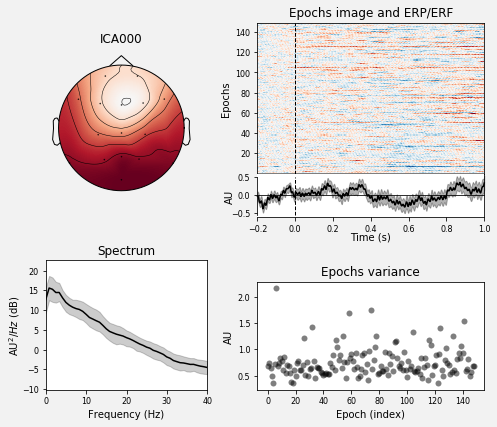

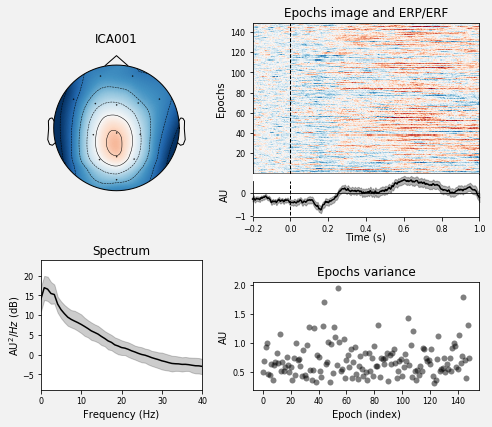

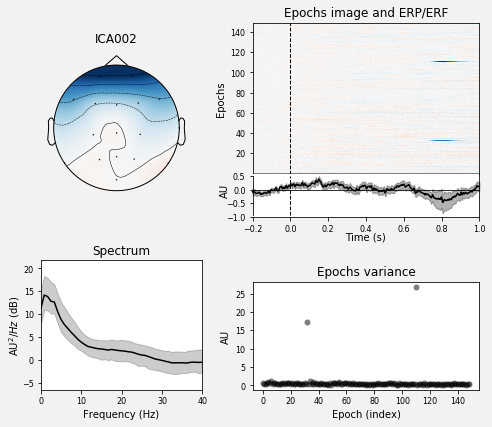

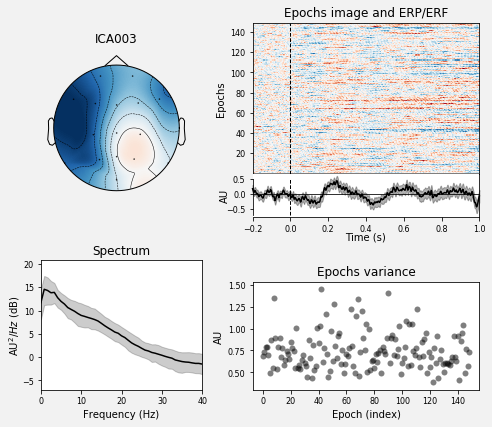

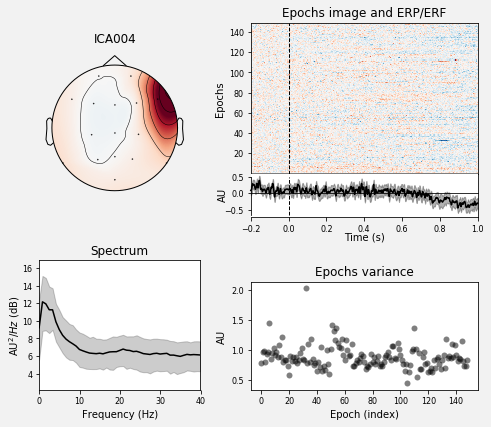

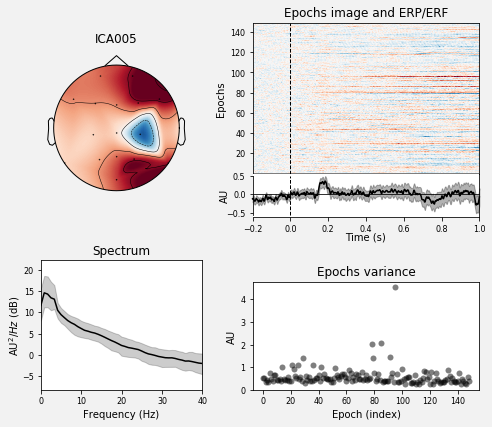

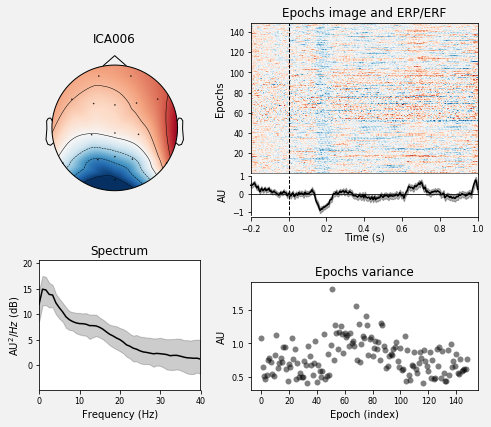

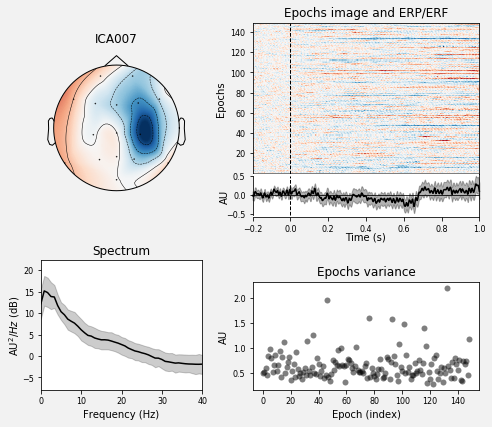

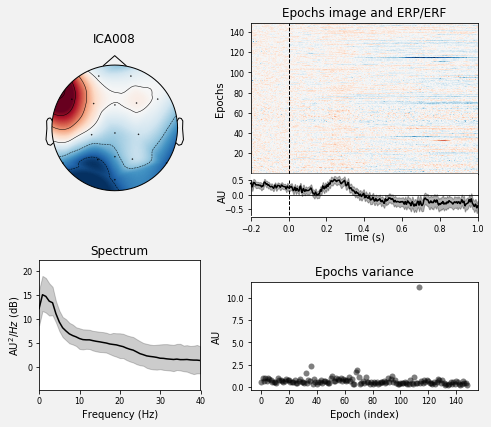

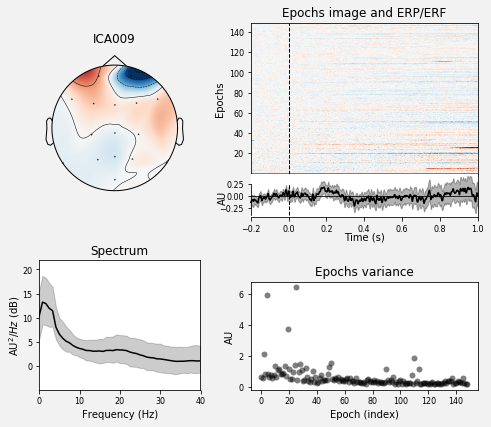

In [22]:
ica.plot_properties(epochs, picks=range(0,ica.n_components_), psd_args={'fmax': h_freq});

### Manually specify ICs to remove, based on visual inspection
The automatic process doesn't remove as many ICs as necessary for EEG

In [23]:
ica.exclude = [2,4,7,9]

# Apply ICA corrections to data, and re-reference to average mastoids

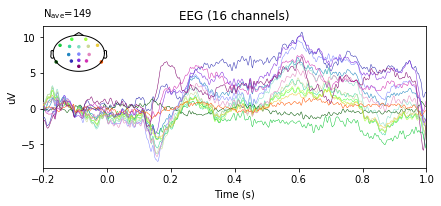

In [24]:
epochs_postica = ica.apply(epochs.copy()).apply_baseline(baseline)
epochs_postica_mstd = set_eeg_reference(epochs_postica, ref_channels=['TP9','TP10'])[0]
epochs_postica_mstd.interpolate_bads()

epochs_postica_mstd.average().plot(spatial_colors=True);

## Check epochs again and remove any that ICA didn't clean up

In [25]:
%matplotlib qt5
epochs_postica_mstd.plot(scalings=dict(eeg=.0002), n_channels=16, title='Epochs post-ICA');

In [26]:
rej_trials = [114]
for k in range(len(rej_trials)):
    rej_trials[k] = rej_trials[k]-1
    
epochs_postica_mstd.drop(rej_trials)

<Epochs  |   148 events (all good), -0.2 - 1 sec, baseline [None, 0], ~10.9 MB, data loaded,
 'AdjectiveViol': 50
 'Control': 49
 'NounViol': 49>

In [27]:
epochs_postica_mstd.save(epochs_fname)

# Create Evoked Responses (averaged epochs for each condition)
This will save a file of the evoked data as well, which you will load in later, in a different script, for group data analysis).

In [28]:
evokeds = {cond:epochs_postica_mstd[cond].average() 
           for cond in event_id.keys()}

mne.write_evokeds(evoked_fname, list(evokeds.values()))

### Plot averaged ERP for each condition
Note that for any image in a jupyter notebook (such as these plots), you can right-click and "save as" to save it as an image file (e.g., for inclusion in your lab report).

In [29]:
% matplotlib inline
for cond in evokeds:
    evokeds[cond].plot(spatial_colors=True, titles=cond);

UsageError: Line magic function `%` not found.


### Topoplots for each condition
In 100 ms steps

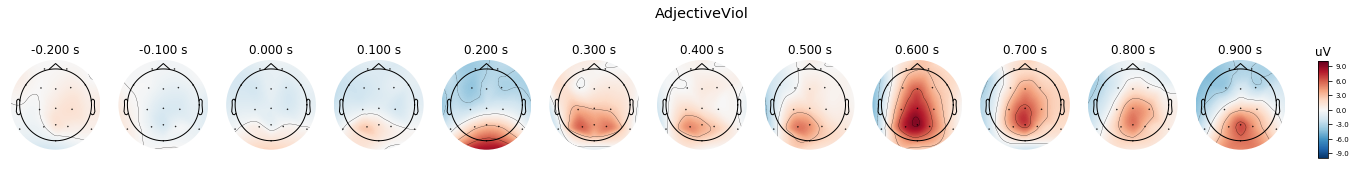

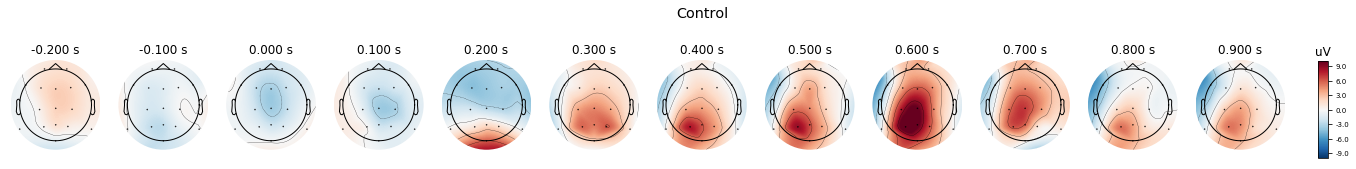

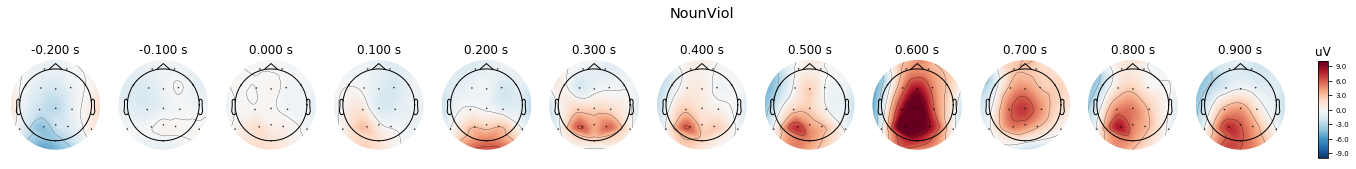

In [30]:
%matplotlib inline
# Specify times to plot at, in sec, as [min], [max], [stepsize]
times = np.arange(tmin, tmax, 0.1)

for cond in sorted(evokeds):
    [evokeds[cond].plot_topomap(outlines='skirt', 
                                times=times, 
                                title=cond,
                                vmin=-10., vmax=10.)];

## Plot each condition, overlaid, at one electrode

You can replace 'Cz' with channel name desired


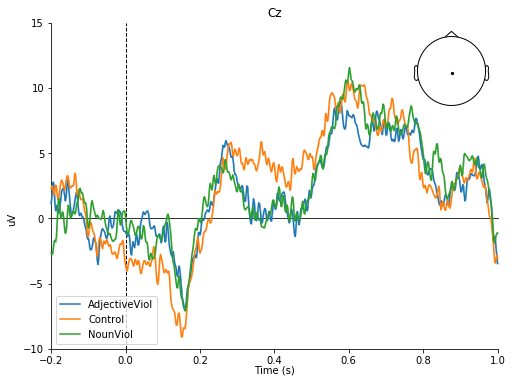

In [31]:
pick = evokeds[list(evokeds.keys())[0]].ch_names.index('Cz')

mne.viz.plot_compare_evokeds(evokeds, picks=pick, 
                             ylim = dict(eeg=[-10, 15]));
# note that the 'ylim' line above sets the microvolt scale. Adjust as needed for your data.

# Compute Between-Condition Differences

In [32]:
diffs = {contr:mne.combine_evoked([evokeds[expt_contrasts[contr][0]], 
                                   -evokeds[expt_contrasts[contr][1]]],
                                  weights="equal") 
         for contr in expt_contrasts}

## Plot difference waves

### Plot each contrast, overlaid, at one electrode

You can replace 'Cz' with channel name desired

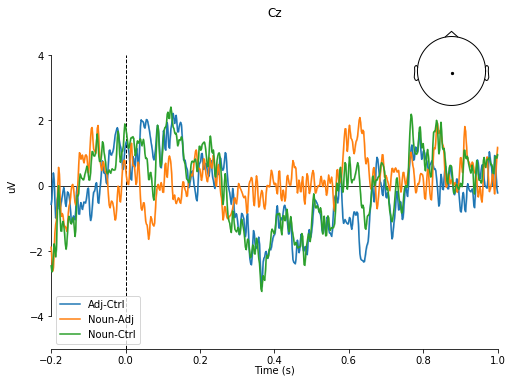

In [33]:
pick = evokeds[list(evokeds.keys())[0]].ch_names.index('Cz')

mne.viz.plot_compare_evokeds(diffs, picks=pick,
                            ylim = dict(eeg=[-5, 5]));

### Plot topomaps of differences at 100 ms intervals

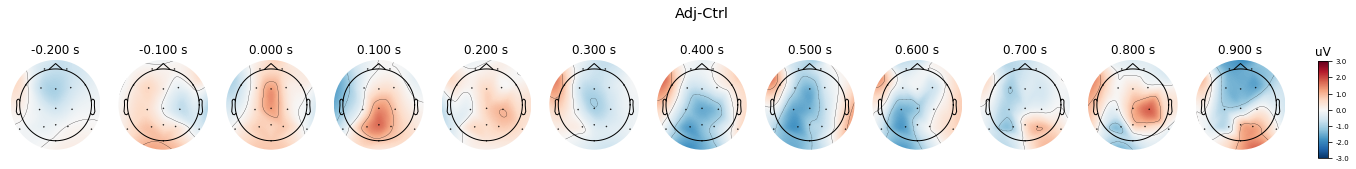

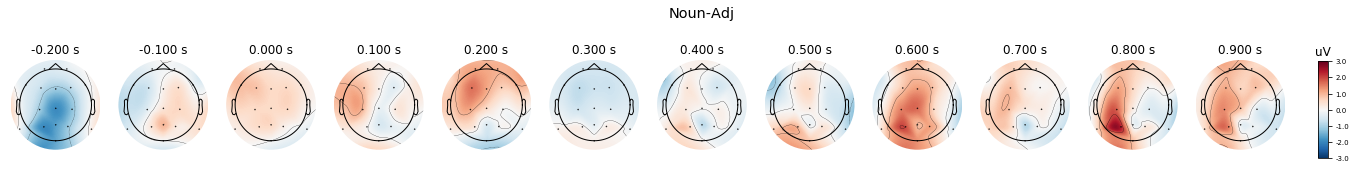

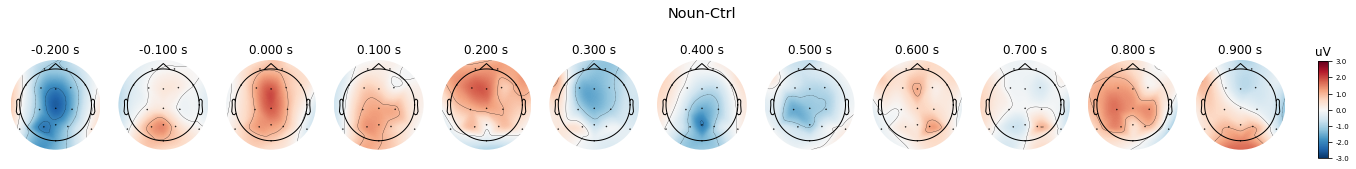

In [34]:
%matplotlib inline
times = np.arange(tmin, tmax, 0.1)
    
{diffs[contr].plot_topomap(outlines='skirt', 
                           times=times, 
                           title=contr,
                           vmin=-3., vmax=3.)
    for contr in sorted(expt_contrasts)};

## Plot mean amplitude over time window of interest

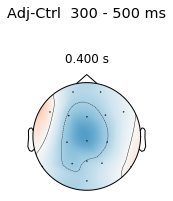

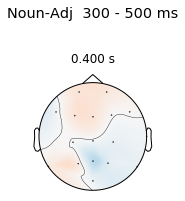

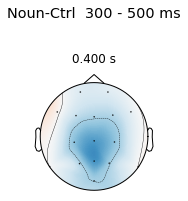

In [35]:
tw = (0.300, 0.500)

tw_ctr = (tw[1]-tw[0])/2 + tw[0]
tw_text = "%03d" % (1000*tw[0]) + ' - ' + "%03d" % (1000*tw[1])

{diffs[contr].plot_topomap(tw_ctr, 
                              average=tw[1]-tw[0],
                              ch_type='eeg', 
                              show_names=False, 
                              colorbar=False, 
                              size=1.5, 
                              res=256,
                              title=str(contr + '  ' + tw_text + ' ms'),
                              vmin=-3., vmax=3.
                             )
 for contr in sorted(expt_contrasts)};